In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


df = pd.read_csv("../data/processed/plan_parsed.csv", parse_dates=["planned_ts", "changed_ts"])

In [2]:
print(df.head())

        station  eva                             stop_id event  \
0  Hannover Hbf  NaN    6395030481339666658-2509150608-9    ar   
1  Hannover Hbf  NaN  -6139144156846071435-2509150712-13    ar   
2  Hannover Hbf  NaN    5098133511292367195-2509150617-4    ar   
3  Hannover Hbf  NaN    6395030481339666658-2509150608-9    dp   
4  Hannover Hbf  NaN  -6139144156846071435-2509150712-13    dp   

                 planned_ts changed_ts  delay_min platform_planned  \
0 2025-09-15 07:58:00+02:00        NaT        NaN                4   
1 2025-09-15 08:00:00+02:00        NaT        NaN                1   
2 2025-09-15 08:01:00+02:00        NaT        NaN                9   
3 2025-09-15 08:01:00+02:00        NaT        NaN                4   
4 2025-09-15 08:03:00+02:00        NaT        NaN                1   

   platform_current line  path  status  
0               NaN  NaN   NaN     NaN  
1               NaN    2   NaN     NaN  
2               NaN  NaN   NaN     NaN  
3               Na

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype                    
---  ------            --------------  -----                    
 0   station           83 non-null     object                   
 1   eva               0 non-null      float64                  
 2   stop_id           83 non-null     object                   
 3   event             83 non-null     object                   
 4   planned_ts        83 non-null     datetime64[ns, UTC+02:00]
 5   changed_ts        0 non-null      datetime64[ns]           
 6   delay_min         0 non-null      float64                  
 7   platform_planned  83 non-null     object                   
 8   platform_current  0 non-null      float64                  
 9   line              51 non-null     object                   
 10  path              0 non-null      float64                  
 11  status            0 non-null      float64      

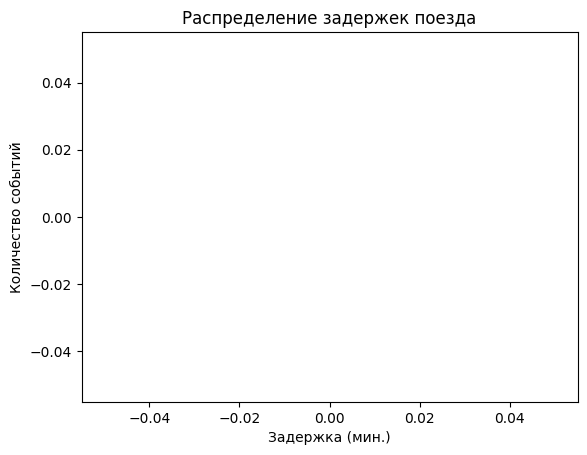

In [4]:
sns.histplot(df["delay_min"].dropna(), bins=30, kde=False)
plt.xlabel("Задержка (мин.)")
plt.ylabel("Количество событий")
plt.title("Распределение задержек поезда")
plt.show()

event
ar   NaN
dp   NaN
Name: delay_min, dtype: float64


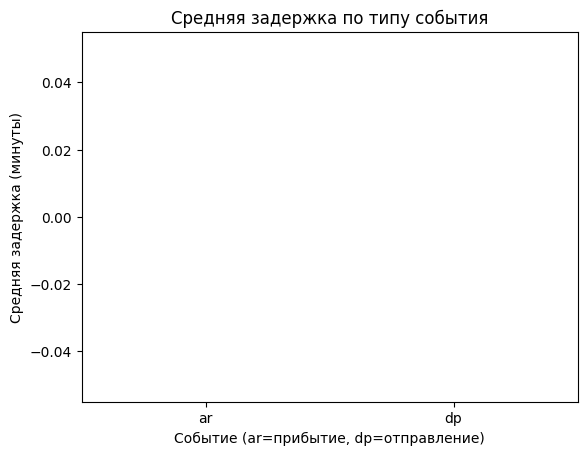

In [5]:
# Средняя задержка по типу события
avg_delays = df.groupby("event")["delay_min"].mean().round(1)
print(avg_delays)

sns.barplot(x=avg_delays.index, y=avg_delays.values)
plt.ylabel("Средняя задержка (минуты)")
plt.xlabel("Событие (ar=прибытие, dp=отправление)")
plt.title("Средняя задержка по типу события")
plt.show()

In [6]:
# Берем только те строки, где есть задержка >0
df_delayed = df[df["delay_min"].notna() & (df["delay_min"] > 0)]

top_platforms = (
    df_delayed.groupby("platform")["delay_min"]
    .mean()
    .sort_values(ascending=False)
    .head(5)
)

print(top_platforms)

sns.barplot(x=top_platforms.index, y=top_platforms.values)
plt.ylabel("Средняя задержка (минуты)")
plt.xlabel("Платформа")
plt.title("Топ-5 платформ с наибольшей средней задержкой")
plt.show()

KeyError: 'platform'

In [ ]:
# базовые фичи времени (от planned_ts; если пусто — fallback на changed_ts)
ts = df["planned_ts"].fillna(df["changed_ts"])
df["hour"] = ts.dt.hour
df["weekday"] = ts.dt.dayofweek  # 0=Mon ... 6=Sun
df["is_peak"] = df["hour"].between(7,9) | df["hour"].between(16,19)
df["is_weekend"] = df["weekday"] >= 5

# бинарка задержки > 5 минут (можно варьировать порог)
df["delayed_5m"] = (df["delay_min"].fillna(0) > 5).astype(int)

df.head()

In [ ]:
n = len(df)
share_5m = df["delayed_5m"].mean()
mean_delay_pos = df.loc[df["delay_min"]>0, "delay_min"].mean()

print(f"Всего событий: {n}")
print(f"Доля задержек >5 мин: {share_5m:.2%}")
print(f"Средняя задержка среди опоздавших: {mean_delay_pos:.1f} мин")

In [ ]:
pivot = (df
         .dropna(subset=["delay_min"])
         .groupby(["weekday","hour"])["delay_min"]
         .mean()
         .unstack(fill_value=0))

plt.figure(figsize=(10,5))
sns.heatmap(pivot, annot=False)
plt.title("Средняя задержка (мин) по дню недели и часу")
plt.xlabel("Час")
plt.ylabel("День недели (0=Пн ... 6=Вс)")
plt.show()


In [ ]:
def agg_metric(g):
    return pd.Series({
        "share_5m": g["delayed_5m"].mean(),
        "mean_delay_pos": g.loc[g["delay_min"]>0, "delay_min"].mean()
    })

by_peak = df.groupby("is_peak").apply(agg_metric)
by_weekend = df.groupby("is_weekend").apply(agg_metric)

print("Пик vs не-пик:\n", by_peak)
print("\nБудни vs выходные:\n", by_weekend)